# YouTube Engagement Ranking + Policy 

## Executive Summary
Goal: predict **next-day engagement** and convert predictions into an **operational ranking policy** (what videos to promote tomorrow).

- **Dataset:** YouTube analytics tables (daily video performance + video-level metrics)
- **Primary KPI (target):** next-day **Average % Viewed**
- **Secondary KPI (target):** next-day **Watch Time**
- **Split:** **time-based** train/valid/test to avoid leakage and reflect real deployment

## What I built
I compare ranking policies under a fixed promotion capacity (**Top-K videos/day**):

1. **Baseline:** no smart ranking (reference)
2. **1-stage (pct-only):** rank videos by predicted next-day Avg % Viewed
3. **1-stage (weighted):** rank by a weighted score combining both KPIs
4. **2-stage:** shortlist candidates using one KPI, then rerank using a balanced score

## How success is measured
Because this is a **ranking + decision** problem, I evaluate:
- **Top-K uplift** in Avg % Viewed and Watch Time (vs baseline)
- Tradeoff between “high retention” (Avg % Viewed) and “total time” (Watch Time)

## Outputs saved (for GitHub)
- Tables: `reports/tables/` (policy comparison)
- Figures: `reports/figures/` (KPI comparisons + key plots)


## 0. Setup
Imports, paths, and global configuration (seeds, output folders).

In [400]:
import pandas as pd
from pathlib import Path

RAW = Path("../data/raw/kaggle_youtube_trending")
files = list(RAW.glob("*.csv"))
files

[PosixPath('../data/raw/kaggle_youtube_trending/All_Comments_Final.csv'),
 PosixPath('../data/raw/kaggle_youtube_trending/Aggregated_Metrics_By_Video.csv'),
 PosixPath('../data/raw/kaggle_youtube_trending/Aggregated_Metrics_By_Country_And_Subscriber_Status.csv'),
 PosixPath('../data/raw/kaggle_youtube_trending/Video_Performance_Over_Time.csv')]

## 1. Load data
Read raw CSVs and confirm schema (rows/columns, key identifiers).

In [401]:
video = pd.read_csv(RAW / "Aggregated_Metrics_By_Video.csv")

In [402]:
video.shape

(224, 19)

In [403]:
video.columns.tolist()

['Video',
 'Video title',
 'Video pub\xadlish time',
 'Com\xadments ad\xadded',
 'Shares',
 'Dis\xadlikes',
 'Likes',
 'Sub\xadscribers lost',
 'Sub\xadscribers gained',
 'RPM (USD)',
 'CPM (USD)',
 'Av\xader\xadage per\xadcent\xadage viewed (%)',
 'Av\xader\xadage view dur\xada\xadtion',
 'Views',
 'Watch time (hours)',
 'Sub\xadscribers',
 'Your es\xadtim\xadated rev\xaden\xadue (USD)',
 'Im\xadpres\xadsions',
 'Im\xadpres\xadsions click-through rate (%)']

In [404]:
perf = pd.read_csv(RAW / "Video_Performance_Over_Time.csv")

In [405]:
perf.shape

(111857, 14)

In [406]:
perf.columns.tolist()

['Date',
 'Video Title',
 'External Video ID',
 'Video Length',
 'Thumbnail link',
 'Views',
 'Video Likes Added',
 'Video Dislikes Added',
 'Video Likes Removed',
 'User Subscriptions Added',
 'User Subscriptions Removed',
 'Average View Percentage',
 'Average Watch Time',
 'User Comments Added']

In [407]:
video.head()

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,NaN,NaN,14197,39640,3902,225021,45790,229241,5.276,11.990,26.61,0:03:25,5568487,317602.3536,183451,29068.652,100954064,3.16
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,"May 8, 2020",907,9583,942,46903,451,46904,6.353,12.835,36.65,0:03:09,1253559,65850.7042,46453,7959.533,26498799,3.14
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,"Nov 12, 2020",412,4,4,130,15,12,2.668,6.259,6.26,0:05:14,2291,200.2966,-3,6.113,188318,0.72
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,"Jul 16, 2020",402,152,15,881,9,198,9.516,11.695,15.12,0:10:21,21350,3687.3387,189,202.963,442334,2.53
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,"Aug 29, 2020",375,367,22,2622,40,1957,3.143,7.943,33.41,0:02:36,49564,2148.3110,1917,155.779,521185,4.01


## 2. Cleaning & QA checks
Fix column names/types, handle missing values, and run sanity checks to ensure metrics are valid.

In [408]:
#clean the columns names
import re

def clean_cols(df):
    df = df.copy()
    df.columns = [re.sub(r"[\u00ad]", "", c).strip() for c in df.columns]  # remove soft hyphen
    return df

video = clean_cols(video)
perf  = clean_cols(perf)

video.columns, perf.columns

(Index(['Video', 'Video title', 'Video publish time', 'Comments added',
        'Shares', 'Dislikes', 'Likes', 'Subscribers lost', 'Subscribers gained',
        'RPM (USD)', 'CPM (USD)', 'Average percentage viewed (%)',
        'Average view duration', 'Views', 'Watch time (hours)', 'Subscribers',
        'Your estimated revenue (USD)', 'Impressions',
        'Impressions click-through rate (%)'],
       dtype='object'),
 Index(['Date', 'Video Title', 'External Video ID', 'Video Length',
        'Thumbnail link', 'Views', 'Video Likes Added', 'Video Dislikes Added',
        'Video Likes Removed', 'User Subscriptions Added',
        'User Subscriptions Removed', 'Average View Percentage',
        'Average Watch Time', 'User Comments Added'],
       dtype='object'))

In [409]:
#rename the columns names:
video = video.rename(columns={
    "Video title": "video_title",
    "Video publish time": "publish_time",
    "Average percentage viewed (%)": "avg_pct_viewed",
    "Average view duration": "avg_view_duration",
    "Watch time (hours)": "watch_time_hours",
    "Impressions click-through rate (%)": "ctr_pct",
    "Your estimated revenue (USD)": "revenue_usd",
})

perf = perf.rename(columns={
    "Date": "date",
    "Video Title": "video_title",
    "External Video ID": "video_id",
    "Video Length": "video_length",
    "Thumbnail link": "thumbnail_link",
    "Views": "views_daily",
    "Video Likes Added": "likes_added_daily",
    "Video Dislikes Added": "dislikes_added_daily",
    "Video Likes Removed": "likes_removed_daily",
    "User Subscriptions Added": "subs_added_daily",
    "User Subscriptions Removed": "subs_removed_daily",
    "Average View Percentage": "avg_pct_viewed_daily",
    "Average Watch Time": "avg_watch_time_daily",
    "User Comments Added": "comments_added_daily",
})

In [410]:
video.columns.tolist()

['Video',
 'video_title',
 'publish_time',
 'Comments added',
 'Shares',
 'Dislikes',
 'Likes',
 'Subscribers lost',
 'Subscribers gained',
 'RPM (USD)',
 'CPM (USD)',
 'avg_pct_viewed',
 'avg_view_duration',
 'Views',
 'watch_time_hours',
 'Subscribers',
 'revenue_usd',
 'Impressions',
 'ctr_pct']

In [411]:
perf.columns.tolist()

['date',
 'video_title',
 'video_id',
 'video_length',
 'thumbnail_link',
 'views_daily',
 'likes_added_daily',
 'dislikes_added_daily',
 'likes_removed_daily',
 'subs_added_daily',
 'subs_removed_daily',
 'avg_pct_viewed_daily',
 'avg_watch_time_daily',
 'comments_added_daily']

## 3. Target construction (next-day KPIs)
Create next-day targets:
- `y_next_avg_pct_viewed`
- `y_next_watch_time` (or log version)
These represent **tomorrow’s outcome** for decisions made today.

In [412]:
# make sure date is datetime
perf["date"] = pd.to_datetime(perf["date"], errors="coerce")

In [413]:
# sort so time operations work
perf = perf.sort_values(["video_id", "date"]).reset_index(drop=True)

In [414]:
perf[["video_id", "date", "avg_pct_viewed_daily", "avg_watch_time_daily"]].head()

,video_id,date,avg_pct_viewed_daily,avg_watch_time_daily
0,-3d1NctSv0c,2020-06-17,NaN,NaN
1,-3d1NctSv0c,2020-06-18,NaN,NaN
2,-3d1NctSv0c,2020-06-19,0.089764,306.365223
3,-3d1NctSv0c,2020-06-20,0.110562,377.349303
4,-3d1NctSv0c,2020-06-21,0.127342,434.619482


In [415]:
# the next-day target
# target = tomorrow's avg_pct_viewed_daily for the same video
perf["y_next_avg_pct_viewed"] = perf.groupby("video_id")["avg_pct_viewed_daily"].shift(-1)

# secondary KPI tomorrow too (for later reporting)
perf["next_avg_watch_time"] = perf.groupby("video_id")["avg_watch_time_daily"].shift(-1)

perf[["video_id","date","avg_pct_viewed_daily","y_next_avg_pct_viewed"]].head(10)

,video_id,date,avg_pct_viewed_daily,y_next_avg_pct_viewed
0,-3d1NctSv0c,2020-06-17,NaN,NaN
1,-3d1NctSv0c,2020-06-18,NaN,0.089764
2,-3d1NctSv0c,2020-06-19,0.089764,0.110562
3,-3d1NctSv0c,2020-06-20,0.110562,0.127342
4,-3d1NctSv0c,2020-06-21,0.127342,0.108499
5,-3d1NctSv0c,2020-06-22,0.108499,0.260563
6,-3d1NctSv0c,2020-06-23,0.260563,0.171055
7,-3d1NctSv0c,2020-06-24,0.171055,0.131225
8,-3d1NctSv0c,2020-06-25,0.131225,0.149377
9,-3d1NctSv0c,2020-06-26,0.149377,0.027927


In [416]:
feature_cols = [
    "views_daily",
    "likes_added_daily",
    "dislikes_added_daily",
    "likes_removed_daily",
    "comments_added_daily",
    "subs_added_daily",
    "subs_removed_daily",
    "video_length",
]

model_df = perf[["video_id", "video_title", "date", "y_next_avg_pct_viewed", "next_avg_watch_time"] + feature_cols].copy()

# drop rows where target is missing (usually the last day per video)
model_df = model_df.dropna(subset=["y_next_avg_pct_viewed"]).reset_index(drop=True)

In [417]:
model_df.shape

(110362, 13)

In [418]:
model_df.head()

,video_id,video_title,date,y_next_avg_pct_viewed,next_avg_watch_time,views_daily,likes_added_daily,dislikes_added_daily,likes_removed_daily,comments_added_daily,subs_added_daily,subs_removed_daily,video_length
0,-3d1NctSv0c,"Ken Jee Q & A Live Stream (50,000 Sub Special!)",2020-06-18,0.089764,306.365223,0,10,0,0,0,2,0,3413
1,-3d1NctSv0c,"Ken Jee Q & A Live Stream (50,000 Sub Special!)",2020-06-19,0.110562,377.349303,1378,89,1,2,0,2,4,3413
2,-3d1NctSv0c,"Ken Jee Q & A Live Stream (50,000 Sub Special!)",2020-06-20,0.127342,434.619482,330,14,0,0,0,2,4,3413
3,-3d1NctSv0c,"Ken Jee Q & A Live Stream (50,000 Sub Special!)",2020-06-21,0.108499,370.305638,114,4,0,0,0,1,4,3413
4,-3d1NctSv0c,"Ken Jee Q & A Live Stream (50,000 Sub Special!)",2020-06-22,0.260563,889.302429,69,3,0,0,0,1,0,3413


In [419]:
model_df[["y_next_avg_pct_viewed","next_avg_watch_time"]].describe()

,y_next_avg_pct_viewed,next_avg_watch_time
count,110362.000000,110362.000000
mean,0.350440,216.823668
std,0.232538,190.787976
min,0.000000,0.000000
25%,0.178004,117.403156
50%,0.336828,181.531704
75%,0.476237,268.185524
max,8.476340,5322.300000


y_next_avg_pct_viewed has max = 8.476 \
This metric should be a fraction, and it should be in [0, 1]. So values > 1 are invalid (usually a data definition / parsing issue).

next_avg_watch_time has max = 5322 seconds (~88 minutes) \
This could be real for long videos, but it’s still heavy-tailed and I'll do a robust treatment (log / winsorize) for modeling.

In [420]:
model_df["y_next_avg_pct_viewed"].describe(percentiles=[.99, .995, .999])

count    110362.000000
mean          0.350440
std           0.232538
min           0.000000
50%           0.336828
99%           0.999506
99.5%         1.043220
99.9%         1.326120
max           8.476340
Name: y_next_avg_pct_viewed, dtype: float64

In [421]:
#clean the outlier
model_df = model_df[(model_df["y_next_avg_pct_viewed"] >= 0) & (model_df["y_next_avg_pct_viewed"] <= 1)]

In [422]:
#check
model_df["y_next_avg_pct_viewed"].describe(percentiles=[.99, .995, .999])

count    109516.000000
mean          0.344042
std           0.218465
min           0.000000
50%           0.334823
99%           0.994995
99.5%         0.998646
99.9%         0.999938
max           1.000000
Name: y_next_avg_pct_viewed, dtype: float64

In [423]:
# heavy_tailed treated
import numpy as np
model_df["y_next_watch_time_log"] = np.log1p(model_df["next_avg_watch_time"])

In [424]:
model_df["y_next_watch_time_log"].describe()

count    109516.000000
mean          5.017322
std           1.014652
min           0.000000
25%           4.769936
50%           5.202595
75%           5.585970
max           8.522981
Name: y_next_watch_time_log, dtype: float64

In [425]:
#check the missing values
model_df[["y_next_avg_pct_viewed","next_avg_watch_time"]].isna().mean()

y_next_avg_pct_viewed    0.0
next_avg_watch_time      0.0
dtype: float64

## 4. Time-based train/valid/test split
Split by date to avoid leakage and simulate production deployment.

In [426]:
#time-based spilt
model_df["date"] = pd.to_datetime(model_df["date"])
model_df = model_df.sort_values(["date", "video_id"]).reset_index(drop=True)

d1 = model_df["date"].quantile(0.60)
d2 = model_df["date"].quantile(0.80)

train_df = model_df[model_df["date"] <= d1].copy()
valid_df = model_df[(model_df["date"] > d1) & (model_df["date"] <= d2)].copy()
test_df  = model_df[model_df["date"] > d2].copy()

print(train_df.shape, valid_df.shape, test_df.shape)
print(train_df["date"].min(), train_df["date"].max())
print(valid_df["date"].min(), valid_df["date"].max())
print(test_df["date"].min(),  test_df["date"].max())

(59909, 14) (19949, 14) (19958, 14)
2017-11-01 00:00:00 2021-04-28 00:00:00
2021-04-29 00:00:00 2021-08-26 00:00:00
2021-08-27 00:00:00 2022-01-19 00:00:00


## 5. Feature set
Define feature columns available at day *t* to predict outcomes at day *t+1*.

In [427]:
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target1 = "y_next_avg_pct_viewed"     # primary
target2 = "next_avg_watch_time"       # secondary

drop_cols = ["video_id", "video_title", "date", target1, target2]
feature_cols = [c for c in model_df.columns if c not in drop_cols]


In [428]:
model_df.columns.tolist()

['video_id',
 'video_title',
 'date',
 'y_next_avg_pct_viewed',
 'next_avg_watch_time',
 'views_daily',
 'likes_added_daily',
 'dislikes_added_daily',
 'likes_removed_daily',
 'comments_added_daily',
 'subs_added_daily',
 'subs_removed_daily',
 'video_length',
 'y_next_watch_time_log']

Define X (features) and y (targets)

In [429]:
feature_cols = [
    "views_daily",
    "likes_added_daily",
    "dislikes_added_daily",
    "likes_removed_daily",
    "comments_added_daily",
    "subs_added_daily",
    "subs_removed_daily",
    "video_length",
]

Xtr = train_df[feature_cols]
Xva = valid_df[feature_cols]
Xte = test_df[feature_cols]

y1_tr = train_df["y_next_avg_pct_viewed"]
y1_va = valid_df["y_next_avg_pct_viewed"]
y1_te = test_df["y_next_avg_pct_viewed"]

y2_tr = train_df["y_next_watch_time_log"]
y2_va = valid_df["y_next_watch_time_log"]
y2_te = test_df["y_next_watch_time_log"]

print("X shapes:", Xtr.shape, Xva.shape, Xte.shape)
print("y1 mean (train/valid/test):", y1_tr.mean(), y1_va.mean(), y1_te.mean())
print("y2 mean (train/valid/test):", y2_tr.mean(), y2_va.mean(), y2_te.mean())

X shapes: (59909, 8) (19949, 8) (19958, 8)
y1 mean (train/valid/test): 0.3486705571025885 0.3376555261753346 0.3411819695166561
y2 mean (train/valid/test): 5.070724427706094 4.984239885390641 4.906453999885235


## 6. Baseline models
Train simple models first (fast, stable) and evaluate with MAE/RMSE/R².
Primary goal is **ranking quality**, not perfect regression fit.

Train + evaluate model for KPI 1

In [430]:
# train the model
from sklearn.ensemble import HistGradientBoostingRegressor

m1 = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

m1.fit(Xtr, y1_tr)
print("trained m1")

trained m1


In [431]:
# predict on valid and test
p1_va = m1.predict(Xva)
p1_te = m1.predict(Xte)

print("pred range valid:", p1_va.min(), p1_va.max())
print("pred range test :", p1_te.min(), p1_te.max())

pred range valid: 0.04987581344857509 0.6907321071833884
pred range test : 0.0630888703825047 0.7097965454168929


In [432]:
#evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_reg(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)     # no squared=False
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}")

eval_reg("PctViewed VALID", y1_va, p1_va)
eval_reg("PctViewed TEST ", y1_te, p1_te)

PctViewed VALID: MAE=0.1214  RMSE=0.1730  R2=0.3757
PctViewed TEST : MAE=0.1325  RMSE=0.1824  R2=0.3631


Train + evaluate model for KPI 2

In [433]:
from sklearn.ensemble import HistGradientBoostingRegressor

m2 = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42
)

m2.fit(Xtr, y2_tr)
print("trained m2")

trained m2


In [434]:
p2_va = m2.predict(Xva)
p2_te = m2.predict(Xte)

print("pred log range valid:", p2_va.min(), p2_va.max())
print("pred log range test :", p2_te.min(), p2_te.max())

pred log range valid: 2.8293855112886668 6.5425378275871555
pred log range test : 2.8504829096641404 6.540409792460434


In [435]:
eval_reg("WatchTime(log) VALID", y2_va, p2_va)
eval_reg("WatchTime(log) TEST ", y2_te, p2_te)

WatchTime(log) VALID: MAE=0.5556  RMSE=0.9159  R2=0.2520
WatchTime(log) TEST : MAE=0.5950  RMSE=0.9517  R2=0.2380


In [436]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_reg_raw(name, y_log_true, y_log_pred):
    y_true = np.expm1(y_log_true)
    y_pred = np.expm1(y_log_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"{name}: MAE={mae:.2f}  RMSE={rmse:.2f}  R2={r2:.4f}")

eval_reg_raw("WatchTime RAW VALID", y2_va, p2_va)
eval_reg_raw("WatchTime RAW TEST ", y2_te, p2_te)

WatchTime RAW VALID: MAE=90.56  RMSE=187.95  R2=0.1235
WatchTime RAW TEST : MAE=93.48  RMSE=185.12  R2=0.1171


## 7. Ranking policies (Top-K decisioning)
Convert predictions into operational decisions:
- 1-stage policies (pct-only / weighted)
- 2-stage policy (shortlist → rerank)

7.1 Build a score table

In [437]:
# Replace df_va/df_te with whatever dataframe aligns row-by-row with Xva/Xte
score_tr = train_df[['video_id','video_title','date',"video_length"]].copy()
score_va = valid_df[['video_id','video_title','date',"video_length"]].copy()
score_te = test_df[['video_id','video_title','date',"video_length"]].copy()

score_tr['y_next_avg_pct_viewed'] = train_df['y_next_avg_pct_viewed'].values
score_va['y_next_avg_pct_viewed'] = valid_df['y_next_avg_pct_viewed'].values
score_te['y_next_avg_pct_viewed'] = test_df['y_next_avg_pct_viewed'].values

score_tr['y_next_watch_time_log'] = train_df['y_next_watch_time_log'].values
score_va['y_next_watch_time_log'] = valid_df['y_next_watch_time_log'].values
score_te['y_next_watch_time_log'] = test_df['y_next_watch_time_log'].values

# Add predictions
score_va['pred_pct'] = p1_va
score_te['pred_pct'] = p1_te

score_va['pred_watch_log'] = p2_va
score_te['pred_watch_log'] = p2_te

score_va.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log
59909,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.273325,5.590051
59910,-kX2b6TF_9k,By The Numbers: Where Should The NBA Put a 4 P...,2021-04-29,656,0.707652,6.142509,0.259650,4.528424
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988


7.2  Scale the two predictions(weighted):\
score = 0.7*pred_pct + 0.3*pred_watch_log

In [438]:
# check the range
score_va[['pred_pct','pred_watch_log']].describe()

,pred_pct,pred_watch_log
count,19949.000000,19949.000000
mean,0.347110,5.065084
std,0.130827,0.530677
min,0.049876,2.829386
25%,0.250981,4.857834
50%,0.365871,5.096642
75%,0.437981,5.344409
max,0.690732,6.542538


7.3 Use standardscaler => z-score:


In [439]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

scaler.fit(np.c_[score_va['pred_pct'], score_va['pred_watch_log']])

score_va[['pred_pct_z','pred_watch_z']] = scaler.transform(
    np.c_[score_va['pred_pct'], score_va['pred_watch_log']]
)

score_te[['pred_pct_z','pred_watch_z']] = scaler.transform(
    np.c_[score_te['pred_pct'], score_te['pred_watch_log']]
)

In [440]:
score_va[['pred_pct_z','pred_watch_z']].describe()

,pred_pct_z,pred_watch_z
count,1.994900e+04,1.994900e+04
mean,-1.740436e-14,-1.370009e-14
std,1.000025e+00,1.000025e+00
min,-2.272022e+00,-4.213021e+00
25%,-7.347962e-01,-3.905489e-01
50%,1.434077e-01,5.946961e-02
75%,6.946115e-01,5.263682e-01
max,2.626609e+00,2.784161e+00


means near 0 and std near 1

In [441]:
w_pct = 0.7
w_watch = 0.3
# for prediction
score_va['score'] = w_pct*score_va['pred_pct_z'] + w_watch*score_va['pred_watch_z']
score_te['score'] = w_pct*score_te['pred_pct_z'] + w_watch*score_te['pred_watch_z']


In [442]:
#for true points
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

cols = ['y_next_avg_pct_viewed','y_next_watch_time_log']

scaler.fit(score_tr[cols].values)

score_tr[['y_next_avg_pct_viewed_z','y_next_watch_time_log_z']] = scaler.transform(score_tr[cols].values)
score_va[['y_next_avg_pct_viewed_z','y_next_watch_time_log_z']] = scaler.transform(score_va[cols].values)
score_te[['y_next_avg_pct_viewed_z','y_next_watch_time_log_z']] = scaler.transform(score_te[cols].values)

In [443]:
score_tr['true_score'] = w_pct*score_tr['y_next_avg_pct_viewed_z'] + w_watch*score_tr['y_next_watch_time_log_z']
score_va['true_score'] = w_pct*score_va['y_next_avg_pct_viewed_z'] + w_watch*score_va['y_next_watch_time_log_z']
score_te['true_score'] = w_pct*score_te['y_next_avg_pct_viewed_z'] + w_watch*score_te['y_next_watch_time_log_z']

In [444]:
#check
score_va[["pred_pct", "pred_watch_log", "pred_pct_z", "pred_watch_z","score"]].describe()

,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score
count,19949.000000,19949.000000,1.994900e+04,1.994900e+04,1.994900e+04
mean,0.347110,5.065084,-1.740436e-14,-1.370009e-14,-1.629700e-14
std,0.130827,0.530677,1.000025e+00,1.000025e+00,6.295654e-01
min,0.049876,2.829386,-2.272022e+00,-4.213021e+00,-2.186164e+00
25%,0.250981,4.857834,-7.347962e-01,-3.905489e-01,-3.966946e-01
50%,0.365871,5.096642,1.434077e-01,5.946961e-02,4.600248e-02
75%,0.437981,5.344409,6.946115e-01,5.263682e-01,5.057240e-01
max,0.690732,6.542538,2.626609e+00,2.784161e+00,1.548095e+00


In [445]:
score_te[['y_next_avg_pct_viewed','y_next_avg_pct_viewed_z','y_next_watch_time_log_z',
          'y_next_watch_time_log',
          "true_score"]].describe()

,y_next_avg_pct_viewed,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,y_next_watch_time_log,true_score
count,19958.000000,19958.000000,19958.000000,19958.000000,19958.000000
mean,0.341182,-0.034838,-0.170638,4.906454,-0.075578
std,0.228604,1.063500,1.132495,1.090236,0.934817
min,0.000000,-1.622067,-5.267274,0.000000,-2.715629
25%,0.158543,-0.884500,-0.519770,4.570350,-0.588197
50%,0.328261,-0.094950,0.079204,5.146973,-0.025221
75%,0.480242,0.612088,0.506705,5.558522,0.489531
max,1.000000,3.030080,3.380834,8.325402,3.082635


7.4 Rank scores

In [446]:
score_va_ranked = score_va.copy()
score_te_ranked = score_te.copy()

pct_va_ranked = score_va.copy()
pct_te_ranked = score_te.copy()

In [447]:
#1. rank by pct
# rank within each recommendation day
pct_va_ranked["rank_pct"] = (
    score_va_ranked.groupby("date")["pred_pct"]
      .rank(ascending=False, method="first")
)   # high score = better,break ties deterministically

# rank within each recommendation day
pct_te_ranked["rank_pct"] = (
    score_te_ranked.groupby("date")["pred_pct"]
      .rank(ascending=False, method="first")
)   # high score = better,break ties deterministically

pct_va_ranked.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_pct
59909,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.273325,5.590051,-0.564000,0.989264,-0.098021,-0.072828,0.731197,0.168380,109.0
59910,-kX2b6TF_9k,By The Numbers: Where Should The NBA Put a 4 P...,2021-04-29,656,0.707652,6.142509,0.259650,4.528424,-0.668529,-1.011299,-0.771360,1.670033,1.113329,1.503022,112.0
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607,-0.124919,0.922472,0.189298,-1.533225,-2.291885,-1.760823,88.0
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006,0.666803,0.425734,0.594482,0.593592,0.384121,0.530750,40.0
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988,0.198023,0.749822,0.363563,0.019982,0.364253,0.123263,66.0


7.5 Pct-only ranking policy

In [448]:
K = 100
topk_pct = pct_va_ranked[pct_va_ranked["rank_pct"] <= K].copy()
topk_pct.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_pct
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607,-0.124919,0.922472,0.189298,-1.533225,-2.291885,-1.760823,88.0
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006,0.666803,0.425734,0.594482,0.593592,0.384121,0.530750,40.0
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988,0.198023,0.749822,0.363563,0.019982,0.364253,0.123263,66.0
59915,1UjMBw_7Gi8,Data Science: Startup vs. Large Corporation,2021-04-29,280,0.971568,5.609615,0.469398,4.532855,0.934758,-1.002950,0.353445,2.897810,0.559778,2.196400,25.0
59917,2KkrtG5IsHo,Reviewing Your Data Science Projects - Episode...,2021-04-29,559,0.129204,4.293537,0.338773,4.575368,-0.063728,-0.922836,-0.321460,-1.020991,-0.807313,-0.956887,86.0


In [449]:
# KPI uplift (real units)
base_pct = score_va["y_next_avg_pct_viewed"].mean()
topk_pct_pct = topk_pct["y_next_avg_pct_viewed"].mean()

base_watch = np.expm1(score_va["y_next_watch_time_log"]).mean()
topk_pct_watch = np.expm1(topk_pct["y_next_watch_time_log"]).mean()

print("AvgPctViewed baseline:", base_pct, "topK:", topk_pct_pct, "uplift:", topk_pct_pct-base_pct)
print("WatchTime(min/whatever unit) baseline:", base_watch, "topK:", topk_pct_watch, "uplift:", topk_pct_watch-base_watch)

AvgPctViewed baseline: 0.3376555261753346 topK: 0.42701568652242794 uplift: 0.08936016034709332
WatchTime(min/whatever unit) baseline: 214.28711725752726 topK: 171.00639886335168 uplift: -43.28071839417558


The ranking policy is selecting videos that people watch “deeper” (higher %), but those videos are associated with lower total watch time next day.

7.5 Weighted-socre ranking policy

In [450]:
#2. rank by weighted score

# rank within each recommendation day
score_va_ranked["rank_score"] = (
    score_va_ranked.groupby("date")["score"]
      .rank(ascending=False, method="first")
)   # high score = better,break ties deterministically

# rank within each recommendation day
score_te_ranked["rank_score"] = (
    score_te_ranked.groupby("date")["score"]
      .rank(ascending=False, method="first")
)   # high score = better,break ties deterministically

score_va_ranked.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_score
59909,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.273325,5.590051,-0.564000,0.989264,-0.098021,-0.072828,0.731197,0.168380,87.0
59910,-kX2b6TF_9k,By The Numbers: Where Should The NBA Put a 4 P...,2021-04-29,656,0.707652,6.142509,0.259650,4.528424,-0.668529,-1.011299,-0.771360,1.670033,1.113329,1.503022,143.0
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607,-0.124919,0.922472,0.189298,-1.533225,-2.291885,-1.760823,66.0
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006,0.666803,0.425734,0.594482,0.593592,0.384121,0.530750,27.0
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988,0.198023,0.749822,0.363563,0.019982,0.364253,0.123263,53.0


In [451]:
score_te_ranked.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_score
79858,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-08-27,964,0.280758,5.604516,0.267239,5.564185,-0.610522,0.940522,-0.145209,-0.315941,0.554482,-0.054814,100.0
79859,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-08-27,866,0.041704,3.614048,0.296954,5.004710,-0.383384,-0.113770,-0.302500,-1.428052,-1.513139,-1.453578,113.0
79860,143WWA5Sy9k,I Eat a Papaya Live on Stream (Plus Q&A for 15...,2021-08-27,5005,0.027211,4.921364,0.102452,4.799196,-1.870132,-0.501048,-1.459407,-1.495478,-0.155149,-1.093380,164.0
79861,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-08-27,482,0.198959,4.573659,0.434343,5.250366,0.666803,0.349152,0.571508,-0.696482,-0.516333,-0.642437,31.0
79862,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-08-27,638,0.408888,5.567851,0.371595,5.446580,0.187164,0.718903,0.346685,0.280141,0.516396,0.351017,61.0


In [452]:
K = 100
topk_weighted = score_va_ranked[score_va_ranked["rank_score"] <= K].copy()
topk_weighted.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_score
59909,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.273325,5.590051,-0.564000,0.989264,-0.098021,-0.072828,0.731197,0.168380,87.0
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607,-0.124919,0.922472,0.189298,-1.533225,-2.291885,-1.760823,66.0
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006,0.666803,0.425734,0.594482,0.593592,0.384121,0.530750,27.0
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988,0.198023,0.749822,0.363563,0.019982,0.364253,0.123263,53.0
59915,1UjMBw_7Gi8,Data Science: Startup vs. Large Corporation,2021-04-29,280,0.971568,5.609615,0.469398,4.532855,0.934758,-1.002950,0.353445,2.897810,0.559778,2.196400,54.0


In [453]:
topk_weighted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 59909 to 79857
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   video_id                 12000 non-null  object        
 1   video_title              12000 non-null  object        
 2   date                     12000 non-null  datetime64[ns]
 3   video_length             12000 non-null  int64         
 4   y_next_avg_pct_viewed    12000 non-null  float64       
 5   y_next_watch_time_log    12000 non-null  float64       
 6   pred_pct                 12000 non-null  float64       
 7   pred_watch_log           12000 non-null  float64       
 8   pred_pct_z               12000 non-null  float64       
 9   pred_watch_z             12000 non-null  float64       
 10  score                    12000 non-null  float64       
 11  y_next_avg_pct_viewed_z  12000 non-null  float64       
 12  y_next_watch_time_log_z  12000 no

In [454]:
# overall average next-day retention (for comparison)
avg_baseline = score_va["true_score"].mean()

avg_topk = topk_weighted["true_score"].mean()

lift = avg_topk - avg_baseline
print("avg_all:", avg_baseline, "avg_topk:", avg_topk, "lift:", lift)

avg_all: -0.06282152498716313 avg_topk: 0.20474716560219341 lift: 0.26756869058935656


The videos I selected as Top-K (based on your predicted score) have true next-day KPI performance that is 0.268 standard deviations higher than the average candidate in the same split.

In [455]:
# KPI uplift (real units)
base_pct = score_va["y_next_avg_pct_viewed"].mean()
topk_weighted_pct = topk_weighted["y_next_avg_pct_viewed"].mean()

base_watch = np.expm1(score_va["y_next_watch_time_log"]).mean()
topk_weighted_watch = np.expm1(topk_weighted["y_next_watch_time_log"]).mean()

print("AvgPctViewed baseline:", base_pct, "topK:", topk_weighted_pct, "uplift:", topk_weighted_pct-base_pct)
print("WatchTime(min/whatever unit) baseline:", base_watch, "topK:", topk_weighted_watch, "uplift:", topk_weighted_watch-base_watch)

AvgPctViewed baseline: 0.3376555261753346 topK: 0.42159235584143423 uplift: 0.08393682966609961
WatchTime(min/whatever unit) baseline: 214.28711725752726 topK: 179.86160270058116 uplift: -34.4255145569461


Compared to the pct-only policy, the weighted-score policy keeps most of the same high-retention videos (high overlap), but reduces the watch-time penalty. In other words, pct-only optimizes “depth” (higher % viewed) but tends to select shorter videos, while the weighted policy balances “depth” and “time,” producing a more business-aligned slate.

In [456]:
score_va[["y_next_avg_pct_viewed", "y_next_watch_time_log"]].corr()

,y_next_avg_pct_viewed,y_next_watch_time_log
y_next_avg_pct_viewed,1.000000,0.413098
y_next_watch_time_log,0.413098,1.000000


Why can Top-K still have lower watch time if corr is positive?

Common reasons:\
    1.Top-K is shorter videos: Short videos can get very high % viewed but still low minutes.\
    2.Top-K has fewer views tomorrow: Even with good retention, low traffic can reduce total watch time.

In [457]:
print("video_length baseline:", score_va["video_length"].mean())
print("video_length topK_weighted:", topk_weighted["video_length"].mean())
print("diff:", topk_weighted["video_length"].mean() - score_va["video_length"].mean())

video_length baseline: 914.4913028221966
video_length topK_weighted: 465.98883333333333
diff: -448.5024694888633


The ranking policy is selecting shorter videos, which mechanically boosts average % viewed because users are more likely to finish short content. However, shorter videos cap total consumption, so next-day watch time decreases even when retention percentage improves.

7.6 Two-stage ranking: \
    1.	Candidate generation: pick top N by retention (pct)\
    2.	Re-rank: within those, pick final K by watch time (or your combined score)

In [458]:
K_final = 100
N_candidates = 1000   # 10x K_final

w_pct = 0.7
w_watch = 0.3

In [459]:
stage_2_ranking_va = score_va.copy()
stage_2_ranking_te = score_te.copy()

In [460]:
def stage2_final(df_candidates, K):
    df_candidates["rank_stage_2"] = (
    df_candidates.groupby("date")["pred_watch_log"]
      .rank(ascending=False, method="first")
    )   # high score = better,break ties deterministically

    return (df_candidates[df_candidates["rank_stage_2"] <= K])

In [461]:
def stage1_candidates(df, N):
    # For each decision day, keep top M by predicted pct viewed
    df["rank_stage_1"] = (
    df.groupby("date")["pred_pct"]
      .rank(ascending=False, method="first")
    )   # high score = better,break ties deterministically

    return (df[df["rank_stage_1"] <= N])

In [462]:
cand_va = stage1_candidates(stage_2_ranking_va, N=N_candidates)
topk2_va = stage2_final(cand_va, K=K_final)

cand_te = stage1_candidates(stage_2_ranking_te, N=N_candidates)
topk2_te = stage2_final(cand_te, K=K_final)

topk2_va.head()

,video_id,video_title,date,video_length,y_next_avg_pct_viewed,y_next_watch_time_log,pred_pct,pred_watch_log,pred_pct_z,pred_watch_z,score,y_next_avg_pct_viewed_z,y_next_watch_time_log_z,true_score,rank_stage_1,rank_stage_2
59909,-ONQ628CXKQ,Data Scientist Reacts: REAL Data Science Job A...,2021-04-29,964,0.333016,5.774636,0.273325,5.590051,-0.564000,0.989264,-0.098021,-0.072828,0.731197,0.168380,109.0,20.0
59911,-pdXWmj9xxU,How I Learn Data Science Through Studying Othe...,2021-04-29,866,0.019097,2.864362,0.330768,5.554607,-0.124919,0.922472,0.189298,-1.533225,-2.291885,-1.760823,88.0,23.0
59912,1Cf7SdnBncg,My Top 5 Data Science Internship Tips,2021-04-29,482,0.476266,5.440512,0.434343,5.291006,0.666803,0.425734,0.594482,0.593592,0.384121,0.530750,40.0,58.0
59913,1FrY7ARSf10,9 Ways You Can Make Extra Income as a Data Sci...,2021-04-29,638,0.352966,5.421385,0.373016,5.462988,0.198023,0.749822,0.363563,0.019982,0.364253,0.123263,66.0,32.0
59914,1Ir1NgCuI0Y,Data Science Resume Round-Up With @Tina Huang ...,2021-04-29,2219,0.339172,6.624893,0.126122,5.306683,-1.689204,0.455277,-1.045860,-0.044188,1.614410,0.453392,154.0,51.0


In [463]:
topk2_va.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 59909 to 79857
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   video_id                 12000 non-null  object        
 1   video_title              12000 non-null  object        
 2   date                     12000 non-null  datetime64[ns]
 3   video_length             12000 non-null  int64         
 4   y_next_avg_pct_viewed    12000 non-null  float64       
 5   y_next_watch_time_log    12000 non-null  float64       
 6   pred_pct                 12000 non-null  float64       
 7   pred_watch_log           12000 non-null  float64       
 8   pred_pct_z               12000 non-null  float64       
 9   pred_watch_z             12000 non-null  float64       
 10  score                    12000 non-null  float64       
 11  y_next_avg_pct_viewed_z  12000 non-null  float64       
 12  y_next_watch_time_log_z  12000 no

In [464]:
#check
topk2_va.groupby("date").size().describe()

count    120.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
dtype: float64

In [465]:
topk2_te.groupby("date").size().describe()

count    116.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
dtype: float64

## 8. Evaluation (Top-K uplift)
Compare policies under fixed capacity:
- Avg % Viewed uplift vs baseline
- Watch Time uplift vs baseline

In [466]:
import numpy as np

def slate_metrics(all_df, slate_df, label=""):
    # baseline across all items (same split)
    base_pct = all_df["y_next_avg_pct_viewed"].mean()
    base_watch = np.expm1(all_df["y_next_watch_time_log"]).mean()

    # slate performance
    slate_pct = slate_df["y_next_avg_pct_viewed"].mean()
    slate_watch = np.expm1(slate_df["y_next_watch_time_log"]).mean()

    out = {
        "label": label,
        "pct_baseline": base_pct,
        "pct_slate": slate_pct,
        "pct_uplift": slate_pct - base_pct,
        "watch_baseline": base_watch,
        "watch_slate": slate_watch,
        "watch_uplift": slate_watch - base_watch,
    }
    return out

m_pct = slate_metrics(score_va, topk_pct,  "VALID |  1-stage (pct only)")
m_weighted = slate_metrics(score_va, topk_weighted, "VALID |  1-stage (weighted score)")
m_stage2 = slate_metrics(stage_2_ranking_va, topk2_va, "VALID | 2-stage (pct→watch)")

m_pct, m_weighted, m_stage2

({'label': 'VALID |  1-stage (pct only)',
  'pct_baseline': np.float64(0.3376555261753346),
  'pct_slate': np.float64(0.42701568652242794),
  'pct_uplift': np.float64(0.08936016034709332),
  'watch_baseline': np.float64(214.28711725752726),
  'watch_slate': np.float64(171.00639886335168),
  'watch_uplift': np.float64(-43.28071839417558)},
 {'label': 'VALID |  1-stage (weighted score)',
  'pct_baseline': np.float64(0.3376555261753346),
  'pct_slate': np.float64(0.42159235584143423),
  'pct_uplift': np.float64(0.08393682966609961),
  'watch_baseline': np.float64(214.28711725752726),
  'watch_slate': np.float64(179.86160270058116),
  'watch_uplift': np.float64(-34.4255145569461)},
 {'label': 'VALID | 2-stage (pct→watch)',
  'pct_baseline': np.float64(0.3376555261753346),
  'pct_slate': np.float64(0.3114656370505626),
  'pct_uplift': np.float64(-0.026189889124771992),
  'watch_baseline': np.float64(214.28711725752726),
  'watch_slate': np.float64(251.3164740416123),
  'watch_uplift': np.fl

Policy 1-stage:\
	•	This policy selects videos that people will watch deeper tomorrow (higher % viewed).\
	•	But they have lower total watch time tomorrow.

Policy 2-stage:
	•	This policy increases watch time tomorrow a lot (+37).\
	•	but viewers watch a smaller fraction of the video tomorrow (-2.6pp).\
    -	Watch-time optimization tends to favor longer videos or videos where sessions run longer. Longer videos usually have lower completion percentage (harder to finish).

• 1-stage ranking (weighted score) increases Avg % Viewed (+8.4pp) but decreases Watch Time (-34).\
    → Best if the product goal is completion / satisfaction / shorter content quality.
        
• 2-stage ranking (Pct → Watch) increases Watch Time (+37) but decreases Avg % Viewed (-2.6pp).\
    → Best if the product goal is total minutes / session length / engagement time.
        
• This is a trade-off, not a bug: percent viewed and watch time conflict because video length changes the metric incentives.

In [467]:
#Compare average video length

def avg_len(df):
    return df["video_length"].mean()


print("VALID baseline avg video_length:", avg_len(score_va))
print("VALID 1-stage(pct only) avg video_length:", avg_len(topk_pct))
print("VALID 1-stage(weighted) avg video_length:", avg_len(topk_weighted))
print("VALID 2-stage avg video_length:", avg_len(topk2_va))

print("\nDiff vs baseline:")
print("1-stage(pct only) - baseline:", avg_len(topk_pct) - avg_len(score_va))
print("1-stage(weighted) - baseline:", avg_len(topk_weighted) - avg_len(score_va))
print("2-stage - baseline:", avg_len(topk2_va) - avg_len(score_va))

VALID baseline avg video_length: 914.4913028221966
VALID 1-stage(pct only) avg video_length: 427.6220833333333
VALID 1-stage(weighted) avg video_length: 465.98883333333333
VALID 2-stage avg video_length: 1103.2654166666666

Diff vs baseline:
1-stage(pct only) - baseline: -486.86921948886334
1-stage(weighted) - baseline: -448.5024694888633
2-stage - baseline: 188.77411384446998


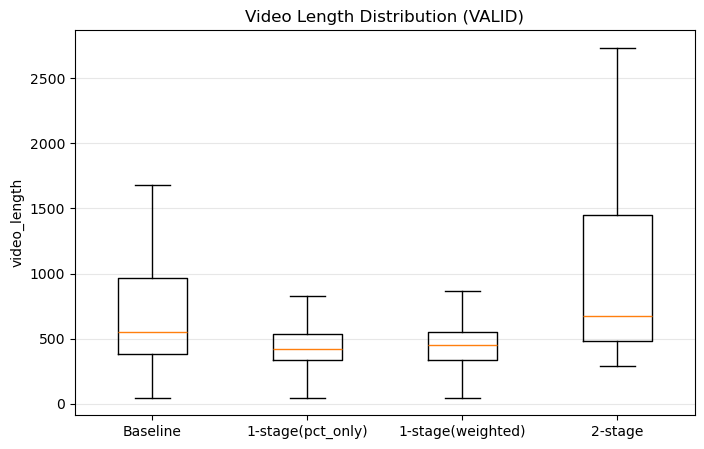

In [468]:
import matplotlib.pyplot as plt

# Boxplot
plt.figure(figsize=(8,5))
plt.boxplot(
    [score_va["video_length"], topk_pct["video_length"], topk_weighted["video_length"], topk2_va["video_length"]],
    tick_labels=["Baseline", "1-stage(pct_only)", "1-stage(weighted)", "2-stage"],
    showfliers=False
)
plt.ylabel("video_length")
plt.title("Video Length Distribution (VALID)")
plt.grid(axis="y", alpha=0.3)
plt.savefig("../reports/figures/Video Length Distribution (VALID).png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

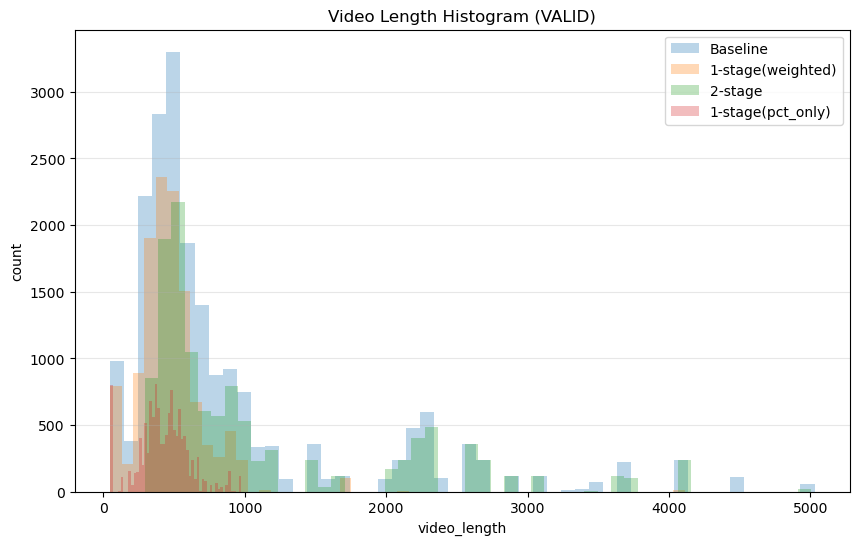

In [469]:
plt.figure(figsize=(10,6))
plt.hist(score_va["video_length"], bins=50, alpha=0.3, label="Baseline")
plt.hist(topk_weighted["video_length"], bins=50, alpha=0.3, label="1-stage(weighted)")
plt.hist(topk2_va["video_length"], bins=50, alpha=0.3, label="2-stage")
plt.hist(topk_pct["video_length"], bins=50, alpha=0.3, label="1-stage(pct_only)")
plt.xlabel("video_length")
plt.ylabel("count")
plt.title("Video Length Histogram (VALID)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.savefig("../reports/figures/Video Length Histogram (VALID).png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

In [499]:
def slate_kpis(all_df, slate_df, label=""):
    base_pct = all_df["y_next_avg_pct_viewed"].mean()
    base_watch = np.expm1(all_df["y_next_watch_time_log"]).mean()

    slate_pct = slate_df["y_next_avg_pct_viewed"].mean()
    slate_watch = np.expm1(slate_df["y_next_watch_time_log"]).mean()

    print(f"\n{label}")
    print(f"Avg % viewed: baseline={base_pct:.4f}, slate={slate_pct:.4f}, uplift={slate_pct-base_pct:+.4f}")
    print(f"Watch time  : baseline={base_watch:.2f}, slate={slate_watch:.2f}, uplift={slate_watch-base_watch:+.2f}")

slate_kpis(score_va, topk_pct, "VALID | 1-stage(pct only)")
slate_kpis(score_va, topk_weighted, "VALID | 1-stage(weighted) w_pct=0.7")
slate_kpis(score_va, topk2_va, "VALID | 2-stage")


VALID | 1-stage(pct only)
Avg % viewed: baseline=0.3377, slate=0.4270, uplift=+0.0894
Watch time  : baseline=214.29, slate=171.01, uplift=-43.28

VALID | 1-stage(weighted) w_pct=0.7
Avg % viewed: baseline=0.3377, slate=0.4265, uplift=+0.0889
Watch time  : baseline=214.29, slate=172.09, uplift=-42.20

VALID | 2-stage
Avg % viewed: baseline=0.3377, slate=0.3115, uplift=-0.0262
Watch time  : baseline=214.29, slate=251.32, uplift=+37.03


Do the test

In [471]:
all_te = score_te     # baseline pool for TEST

K = 100
slate1_pct_te = (
    all_te.sort_values(["date", "pred_pct"], ascending=[True, False])
         .groupby("date", group_keys=False)
         .head(K)
)

slate1_weighted_te = (
    all_te.sort_values(["date", "score"], ascending=[True, False])
         .groupby("date", group_keys=False)
         .head(K)
)

slate2_te = topk2_te

In [500]:
slate_kpis(all_te, slate1_pct_te, "TEST | 1-stage(pct only)")
slate_kpis(all_te, slate1_weighted_te, "TEST | 1-stage(weigted) w_pct=0.7")
slate_kpis(all_te, slate2_te, "TEST | 2-stage")


TEST | 1-stage(pct only)
Avg % viewed: baseline=0.3412, slate=0.4381, uplift=+0.0969
Watch time  : baseline=204.72, slate=162.87, uplift=-41.85

TEST | 1-stage(weigted) w_pct=0.7
Avg % viewed: baseline=0.3412, slate=0.4323, uplift=+0.0911
Watch time  : baseline=204.72, slate=170.38, uplift=-34.34

TEST | 2-stage
Avg % viewed: baseline=0.3412, slate=0.3075, uplift=-0.0337
Watch time  : baseline=204.72, slate=243.63, uplift=+38.91


Both 1-stage optimizes “retention quality.” \
2-stage optimizes “consumption quantity.” \
All are “right” depending on product goals.

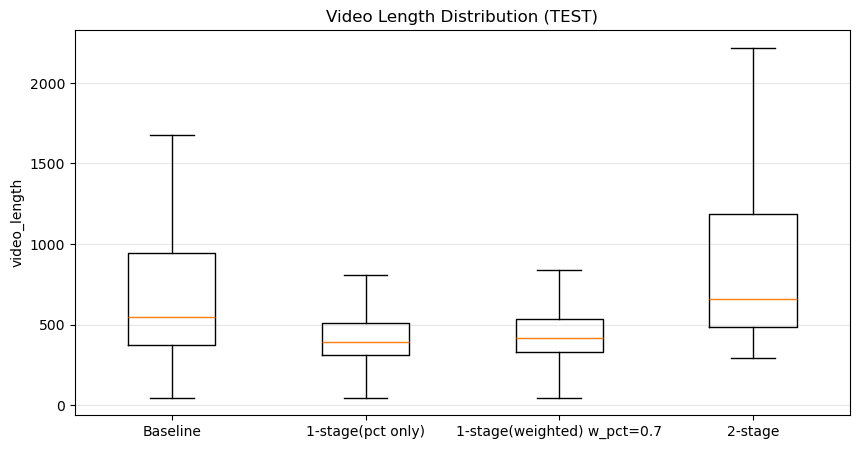

In [502]:
plt.figure(figsize=(10,5))
plt.boxplot(
    [all_te["video_length"], slate1_pct_te["video_length"], slate1_weighted_te["video_length"], slate2_te["video_length"]],
    tick_labels=["Baseline", "1-stage(pct only)","1-stage(weighted) w_pct=0.7", "2-stage"],
    showfliers=False
)
plt.ylabel("video_length")
plt.title("Video Length Distribution (TEST)")
plt.grid(axis="y", alpha=0.3)
plt.savefig("../reports/figures/Video Length Distribution (TEST).png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

In [503]:
print("TEST baseline length:", all_te["video_length"].mean())
print("TEST 1-stage(pct only) length:", slate1_pct_te["video_length"].mean())
print("TEST 1-stage(weighted:w_pct=0.7)length:", slate1_weighted_te["video_length"].mean())
print("TEST 2-stage length:", slate2_te["video_length"].mean())

TEST baseline length: 899.4180278585029
TEST 1-stage(pct only) length: 401.2956896551724
TEST 1-stage(weighted:w_pct=0.7)length: 430.035775862069
TEST 2-stage length: 1108.959224137931


Tune weights on valid

In [479]:
K = 100

def make_topk_by_weight(df, w_pct):
    w_watch = 1 - w_pct
    tmp = df.copy()
    tmp["score_w"] = w_pct*tmp["pred_pct_z"] + w_watch*tmp["pred_watch_z"]

    topk = (tmp.sort_values(["date","score_w"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(K))
    return topk

rows = []
for w_pct in np.linspace(0.1, 0.9, 17):   # 0.10, 0.15, ... 0.90
    topk_weighted = make_topk_by_weight(score_va, w_pct)
    m = slate_metrics(score_va, topk_weighted, label=f"w_pct={w_pct:.2f}")
    rows.append(m)

res = pd.DataFrame(rows).sort_values("pct_uplift", ascending=False)
res

,label,pct_baseline,pct_slate,pct_uplift,watch_baseline,watch_slate,watch_uplift
16,w_pct=0.90,0.337656,0.426540,0.088884,214.287117,172.085914,-42.201203
15,w_pct=0.85,0.337656,0.426511,0.088856,214.287117,172.897763,-41.389354
14,w_pct=0.80,0.337656,0.426002,0.088346,214.287117,173.876485,-40.410632
13,w_pct=0.75,0.337656,0.424632,0.086976,214.287117,175.656219,-38.630899
12,w_pct=0.70,0.337656,0.421592,0.083937,214.287117,179.861603,-34.425515
11,w_pct=0.65,0.337656,0.413156,0.075501,214.287117,191.226940,-23.060177
10,w_pct=0.60,0.337656,0.403289,0.065634,214.287117,203.721666,-10.565451
9,w_pct=0.55,0.337656,0.389438,0.051782,214.287117,215.056315,0.769197
8,w_pct=0.50,0.337656,0.380624,0.042969,214.287117,221.341931,7.054814
7,w_pct=0.45,0.337656,0.372234,0.034578,214.287117,226.811591,12.524474


Pick w_pct = 0.55 and run the TEST

In [480]:
w_pct = 0.55
topk_weighted_te = make_topk_by_weight(score_te, w_pct)
test_metrics = slate_metrics(score_te, topk_weighted_te, label=f"TEST | weighted w_pct={w_pct:.2f}")
test_metrics

{'label': 'TEST | weighted w_pct=0.55',
 'pct_baseline': np.float64(0.3411819695166561),
 'pct_slate': np.float64(0.3901833244150925),
 'pct_uplift': np.float64(0.04900135489843643),
 'watch_baseline': np.float64(204.72039795518359),
 'watch_slate': np.float64(208.06708090960657),
 'watch_uplift': np.float64(3.346682954422988)}

We tuned the ranking weight on VALID to maximize Avg % Viewed uplift subject to non-negative Watch Time uplift. \
The selected policy is w_pct=0.55.

Compare all the outcomes

In [481]:
K = 100
SEED = 42

def random_slate(df, K=100, seed=42):
    # pick K random items per day
    return (df.groupby("date", group_keys=False)
              .apply(lambda g: g.sample(n=min(K, len(g)), random_state=seed)))

def topk_by_col(df, col, K=100, label=None):
    # rank by a single column within each day
    out = (df.sort_values(["date", col], ascending=[True, False])
             .groupby("date", group_keys=False)
             .head(K))
    return out

def two_stage_pct_to_watch(df, N=N_candidates, K=K):
    """
    2-stage recommender:
      Stage 1: keep top-N by pred_pct (candidates)
      Stage 2: rerank candidates by pred_watch_log, take top-K
    """
    # stage 1: candidate generation
    cand = (df.sort_values(["date", "pred_pct"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(N))

    # stage 2: rerank + final slate 
    out = (cand.sort_values(["date", "pred_watch_log"], ascending=[True, False])
              .groupby("date", group_keys=False)
              .head(K))

    return out

def make_topk_by_weight(df, w_pct=0.55, K=100):
    """
    Uses your *predictions* to build a balanced score.
    IMPORTANT: standardize preds using TEST distribution (or VALID if you prefer).
    """
    tmp = df.copy()

    # z-score preds (within the whole split, not per-day)
    tmp["pred_pct_z"] = (tmp["pred_pct"] - tmp["pred_pct"].mean()) / tmp["pred_pct"].std(ddof=0)
    tmp["pred_watch_z"] = (tmp["pred_watch_log"] - tmp["pred_watch_log"].mean()) / tmp["pred_watch_log"].std(ddof=0)

    tmp["score_weighted"] = w_pct * tmp["pred_pct_z"] + (1 - w_pct) * tmp["pred_watch_z"]

    out = (tmp.sort_values(["date", "score_weighted"], ascending=[True, False])
             .groupby("date", group_keys=False)
             .head(K))
    return out

In [482]:
# 1) random
slate_rand = random_slate(score_te, K=K, seed=SEED)

# 2) pct-only
slate_pct  = topk_by_col(score_te, col="pred_pct", K=K)

# 3) watch-only (log)
slate_watch = topk_by_col(score_te, col="pred_watch_log", K=K)

# 4) weighted (balanced)
w_pct = 0.55
slate_weighted = make_topk_by_weight(score_te, w_pct=w_pct, K=K)

# 5) two_stage
slate_two_stage = two_stage_pct_to_watch(score_te, N=1000, K=K)


/var/folders/23/ffpfhtdx4wx901rhxgr55x4w0000gn/T/ipykernel_52997/3163691540.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(K, len(g)), random_state=seed)))


In [488]:
rows = []
rows.append(slate_metrics(score_te, slate_rand,     label=f"random"))
rows.append(slate_metrics(score_te, slate_pct,      label=f"1-stage pct-only"))
rows.append(slate_metrics(score_te, slate_weighted, label=f"1-stage weighted w_pct=0.55"))
rows.append(slate_metrics(score_te, slate_two_stage,   f"2-stage (pct→watch)"))
rows.append(slate_metrics(score_te, slate_watch,    label=f"1-stage watch-only"))

compare_df = pd.DataFrame(rows)

show_cols = ["label", "pct_baseline", "pct_slate", "pct_uplift",
             "watch_baseline", "watch_slate", "watch_uplift"]
compare_df[show_cols]

,label,pct_baseline,pct_slate,pct_uplift,watch_baseline,watch_slate,watch_uplift
0,random,0.341182,0.344432,0.003251,204.720398,208.594872,3.874474
1,1-stage pct-only,0.341182,0.438069,0.096887,204.720398,162.865571,-41.854827
2,1-stage weighted w_pct=0.55,0.341182,0.394168,0.052986,204.720398,205.270915,0.550517
3,2-stage (pct→watch),0.341182,0.307501,-0.033681,204.720398,243.631689,38.911291
4,1-stage watch-only,0.341182,0.307493,-0.033688,204.720398,243.629590,38.909192


In [484]:
compare_df.to_markdown("../reports/tables/policy_comparison.md", index=False)

In [485]:
import os
os.makedirs("reports", exist_ok=True)

compare_df.to_csv("../reports/tables/policy_test_comparison.csv", index=False)
print("Saved to reports/policy_comparison_test.csv")

Saved to reports/policy_comparison_test.csv


Check the overlap

In [486]:
A = set(slate_pct["video_id"])
B = set(slate_weighted["video_id"])

overlap = len(A & B)
union = len(A | B)

print("unique overlap:", overlap)
print("unique union:", union)
print("Jaccard (overlap/union):", overlap / union)
print("overlap % of pct slate:", overlap / len(A))
print("overlap % of weighted slate:", overlap / len(B))

unique overlap: 132
unique union: 176
Jaccard (overlap/union): 0.75
overlap % of pct slate: 0.9295774647887324
overlap % of weighted slate: 0.7951807228915663


Interpretation:\
•	The weighted policy is not a full rewrite of recommendations — it keeps most of the pct-only picks (high overlap).\
•	But it does make meaningful swaps (~20% of the weighted slate differs), which is enough to change outcomes.\
•	This supports the story that the weighted policy is a controlled trade-off: it adjusts a subset of videos to balance WatchTime vs Avg%Viewed, rather than destabilizing the whole slate.

In [487]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


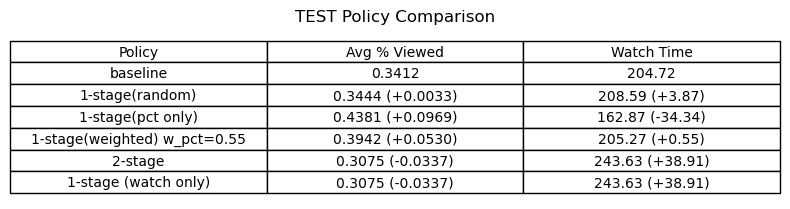

In [494]:
import matplotlib.pyplot as plt

rows = [
    ["baseline", "0.3412", "204.72"],
    ["1-stage(random)",  "0.3444 (+0.0033)", "208.59 (+3.87)"],
    ["1-stage(pct only)",  "0.4381 (+0.0969)", "162.87 (-34.34)"],
    ["1-stage(weighted) w_pct=0.55",  "0.3942 (+0.0530)", "205.27 (+0.55)"],
    ["2-stage",  "0.3075 (-0.0337)", "243.63 (+38.91)"],
    ["1-stage (watch only)",  "0.3075 (-0.0337)", "243.63 (+38.91)"]
]
col_labels = ["Policy", "Avg % Viewed", "Watch Time"]

fig, ax = plt.subplots(figsize=(8, 2.2))
ax.axis("off")
tbl = ax.table(cellText=rows, colLabels=col_labels, loc="center", cellLoc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.35)
plt.title("TEST Policy Comparison", pad=10)
plt.tight_layout()
plt.savefig("../reports/figures/TEST Policy Comparison.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()


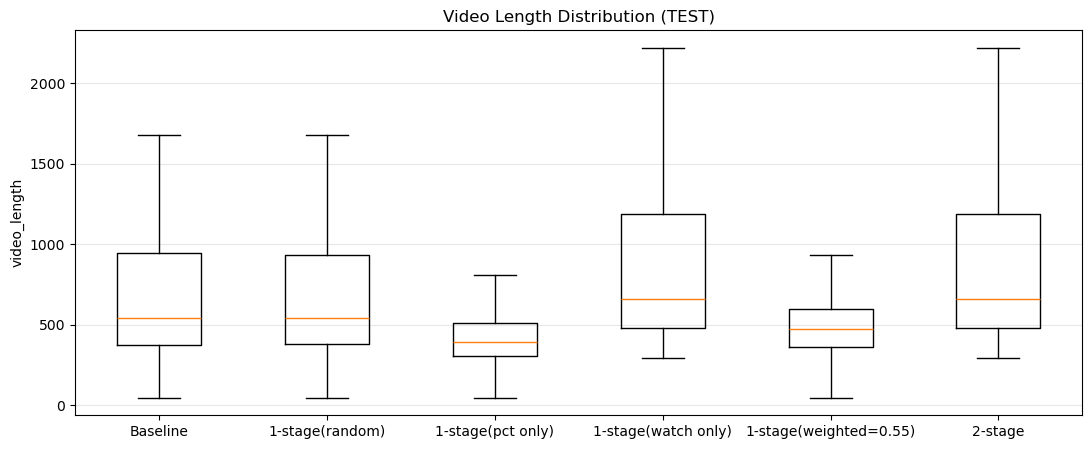

In [527]:
plt.figure(figsize=(13,5))
plt.boxplot(
    [all_te["video_length"], slate_rand["video_length"], slate_pct["video_length"],slate_watch['video_length'], slate_weighted["video_length"], slate_two_stage["video_length"]],
    tick_labels=["Baseline","1-stage(random)", "1-stage(pct only)","1-stage(watch only)","1-stage(weighted=0.55)", "2-stage"],
    showfliers=False
)
plt.ylabel("video_length")
plt.title("Video Length Distribution (TEST)")
plt.grid(axis="y", alpha=0.3)
plt.savefig("../reports/figures/video_length_distribution_test.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()

In [495]:
print("TEST baseline length:", all_te["video_length"].mean())
print("TEST 1-stage(pct only) length:", slate1_pct_te["video_length"].mean())
print("TEST 1-stage(weighted) length:", slate1_weighted_te["video_length"].mean())
print("TEST 2-stage length:", slate2_te["video_length"].mean())

TEST baseline length: 899.4180278585029
TEST 1-stage(pct only) length: 401.2956896551724
TEST 1-stage(weighted) length: 430.035775862069
TEST 2-stage length: 1108.959224137931


In [504]:
print("TEST baseline length:", all_te["video_length"].mean())
print("TEST 1-stage(random) length:", slate_rand["video_length"].mean())
print("TEST 1-stage(pct only) length:", slate_pct["video_length"].mean())
print("TEST 1-stage(watch only) length:", slate_watch["video_length"].mean())
print("TEST 1-stage(weighted:w_pct=0.55) length:", slate_weighted["video_length"].mean())
print("TEST 2-stage length:", slate_two_stage["video_length"].mean())

TEST baseline length: 899.4180278585029
TEST 1-stage(random) length: 897.5486206896552
TEST 1-stage(pct only) length: 401.2956896551724
TEST 1-stage(watch only) length: 1108.959224137931
TEST 1-stage(weighted:w_pct=0.55) length: 648.8294827586207
TEST 2-stage length: 1108.959224137931


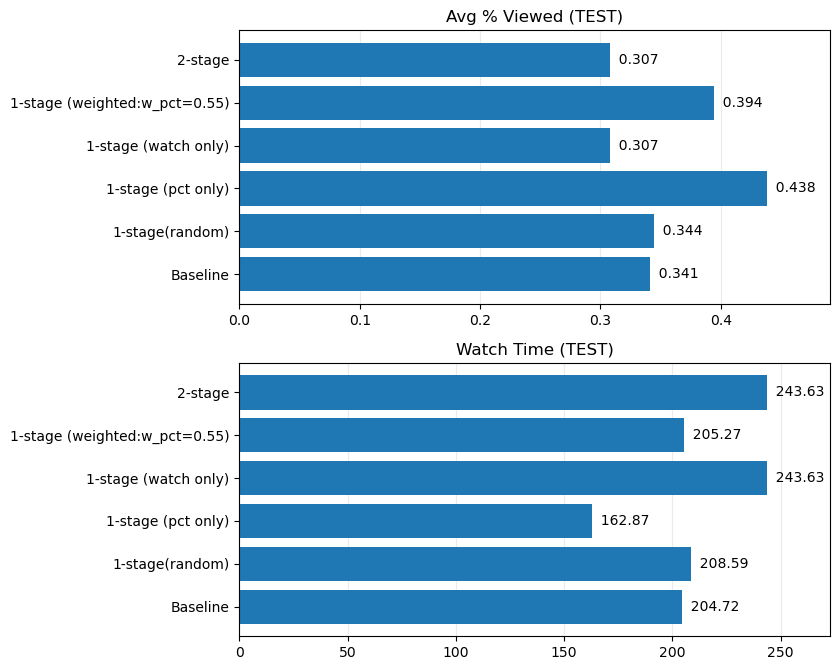

Saved: ../reports/figures/kpis_test.png


In [512]:
labels = ["Baseline", "1-stage(random)","1-stage (pct only)","1-stage (watch only)", "1-stage (weighted:w_pct=0.55)", "2-stage"]
pct   = [0.3412, 0.3444, 0.4381,0.3075, 0.3942, 0.3075]
watch = [204.72, 208.59, 162.87, 243.63,205.27, 243.63]


os.makedirs("../reports/figures", exist_ok=True)

def nice_barh_two(title1, values1, fmt1, title2, values2, fmt2, labels):
    y = np.arange(len(labels))

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8.5, 6.8))

    for ax, title, values, fmt in [
        (axes[0], title1, values1, fmt1),
        (axes[1], title2, values2, fmt2),
    ]:
        bars = ax.barh(y, values)
        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.set_title(title)
        ax.grid(axis="x", alpha=0.25)
        ax.set_axisbelow(True)
        ax.margins(x=0.12)

        for b, v in zip(bars, values):
            ax.text(v, b.get_y() + b.get_height()/2,
                    f"  {fmt.format(v)}",
                    va="center", fontsize=10)

    fig.tight_layout()
    return fig


fig = nice_barh_two(
    "Avg % Viewed (TEST)", pct, "{:.3f}",
    "Watch Time (TEST)", watch, "{:.2f}",
    labels)

outpath = "../reports/figures/kpis_test.png"
fig.savefig(outpath, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)

print("Saved:", outpath)



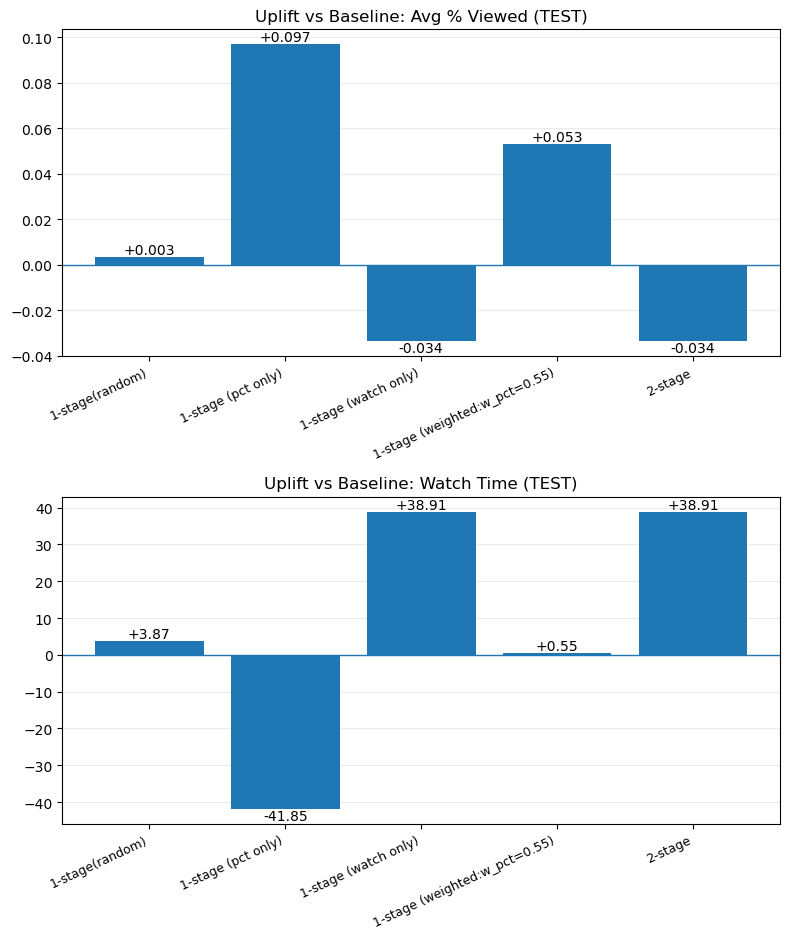

Saved: ../reports/figures/test_kpis_comparison.png


In [517]:
labels = ["1-stage(random)","1-stage (pct only)","1-stage (watch only)", "1-stage (weighted:w_pct=0.55)", "2-stage"]

pct_base = 0.3412
pct_stage = [0.3444, 0.4381,0.3075, 0.3942, 0.3075]
pct_uplift = [v - pct_base for v in pct_stage]


watch_base = 204.72
watch_stage = [208.59, 162.87, 243.63,205.27, 243.63]
watch_uplift = [v - watch_base for v in watch_stage]

os.makedirs("../reports/figures", exist_ok=True)

def uplift_subplot(ax, title, uplift, fmt):
    x = np.arange(len(labels))
    bars = ax.bar(x, uplift)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=9)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.25)
    ax.set_axisbelow(True)

    for b, v in zip(bars, uplift):
        ax.text(
            b.get_x() + b.get_width()/2,
            v,
            fmt.format(v),
            ha="center",
            va="bottom" if v >= 0 else "top",
            fontsize=10
        )

# ---- one combined figure ----
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9.5))

uplift_subplot(axes[0], "Uplift vs Baseline: Avg % Viewed (TEST)", pct_uplift, "{:+.3f}")
uplift_subplot(axes[1], "Uplift vs Baseline: Watch Time (TEST)", watch_uplift, "{:+.2f}")

fig.tight_layout()

outpath = "../reports/figures/test_kpis_comparison.png"
fig.savefig(outpath, dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
plt.close(fig)
print("Saved:", outpath)